In [70]:
import math
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, plot_partial_dependence, partial_dependence
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

client = MongoClient('192.168.0.209', 27017)
db = client['reverb']
sales_coll = db['sales']
data_coll = db['data']
link_coll = db['links']


In [2]:
data_df = pd.DataFrame(list(data_coll.find({},{'_id':0})))
sales_df = pd.DataFrame(list(sales_coll.find({},{'_id':0})))
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%m/%d/%Y')

In [3]:
print(data_df.info())
data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2989 entries, 0 to 2988
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     2989 non-null   object 
 1   brand     2989 non-null   object 
 2   model     2989 non-null   object 
 3   year      2989 non-null   object 
 4   color     2978 non-null   object 
 5   est_low   2989 non-null   float64
 6   est_high  2989 non-null   float64
 7   text      2823 non-null   object 
dtypes: float64(2), object(6)
memory usage: 186.9+ KB
None


,title,brand,model,year,color,est_low,est_high,text
0,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this..."
1,Fender Coronado II 1968 Antigua,Fender,Coronado II,1968,Antigua,1450.0,2235.0,Designed by Roger Rossmeisl who came onto Fend...
2,Fender Stratocaster 1958 Sunburst,Fender,Stratocaster,1958,Sunburst,15635.0,20220.0,Building on the success of the first few years...
3,Fender Stratocaster 1964 Sunburst,Fender,Stratocaster,1964,Sunburst,9800.0,18335.0,"For many collectors, 1964 was an absolute peak..."
4,Epiphone Zephyr 1944 Sunburst,Epiphone,Zephyr,1944,Sunburst,1100.0,1600.0,The Zephyr was an early electric archtop desig...


In [4]:
print(sales_df.info())
sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145324 entries, 0 to 145323
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   title   145324 non-null  object        
 1   date    145324 non-null  datetime64[ns]
 2   cond    145324 non-null  object        
 3   price   145324 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.4+ MB
None


,title,date,cond,price
0,Rickenbacker 660-12 Tom Petty Signature 1992,2021-02-23,Excellent,6495.0
1,Rickenbacker 660-12 Tom Petty Signature 1992,2020-12-07,Excellent,4325.0
2,Rickenbacker 660-12 Tom Petty Signature 1992,2020-10-20,Excellent,7995.0
3,Rickenbacker 660-12 Tom Petty Signature 1992,2020-09-28,Excellent,5495.0
4,Rickenbacker 660-12 Tom Petty Signature 1992,2020-05-26,Excellent,5800.0


In [5]:
sales = sales_df.groupby('title').mean().round(2)
records = sales_df.value_counts('title').to_frame()
data_df = data_df.merge(sales.rename(columns={'price': 'mean_sale'}), on='title')
data_df = data_df.merge(records.rename(columns={0: 'num_records'}), on='title')
data_df.head()

,title,brand,model,year,color,est_low,est_high,text,mean_sale,num_records
0,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54
1,Fender Coronado II 1968 Antigua,Fender,Coronado II,1968,Antigua,1450.0,2235.0,Designed by Roger Rossmeisl who came onto Fend...,2096.55,56
2,Fender Stratocaster 1958 Sunburst,Fender,Stratocaster,1958,Sunburst,15635.0,20220.0,Building on the success of the first few years...,19348.32,16
3,Fender Stratocaster 1964 Sunburst,Fender,Stratocaster,1964,Sunburst,9800.0,18335.0,"For many collectors, 1964 was an absolute peak...",12714.49,59
4,Epiphone Zephyr 1944 Sunburst,Epiphone,Zephyr,1944,Sunburst,1100.0,1600.0,The Zephyr was an early electric archtop desig...,1103.12,8


In [6]:
int_years = pd.Series([int(year) for year in data_df['year'] if year.isdigit()])

# For years that include 'early', 'mid' or 'late' we'll choose a year at random
eml_dict = {
    'early': (0, 4),
    'mid': (4, 7),
    'late': (7, 10)
}

def year_to_int(year):
    # If the year is already a digit, we're done
    if year.isdigit():
        return int(year)
    
    # Check for "early"/"mid"/"late" and build year integer accordingly
    # "Early 70s" becomes a random year between 1970 and 1973 
    for eml, nums in eml_dict.items():
        if eml in year:
            year = year.strip('s').replace("'", '').replace('-', ' ').split()[1]
            year = int('19' + year if len(year) < 4 else year)
            year += np.random.randint(*eml_dict[eml])
            return year
    
    if '-' in year: # Here we find date ranges such as "1938-1943"
        splt = year.split('-')
        low = int(splt[0])
        high = int(splt[1])
        
    else:  # Here we find 2-digit year strings such as "60s"
        # Add 19 if only decade is included
        base = '19' + year if len(year) < 4 else year
        # Remove apostrophes and pluralisations
        base = base.replace("'", '').strip('s')
        low = int(base)
        high = low + 9
    
    # Find average year of all guitars from date range already stored
    avg = round(int_years[(int_years >= low) & (int_years <= high)].mean())
    return avg
    print(year)


In [7]:
data_df['year_str'] = data_df['year']
data_df['year'] = data_df['year'].apply(year_to_int)

In [8]:
merge_df = data_df.merge(sales_df, on='title')
# merge_df = data_df[data_df['year_str'].apply(lambda x: x.isdigit())].merge(sales_df, on='title')  # Uncomment to remove guitars with year ranges
merge_df['age_at_sale'] = merge_df['date'].apply(lambda x: x.year) - merge_df['year']  # Create 'age_at_sale' column
#merge_df.dropna(axis=0, subset=['color'],  inplace=True)
print(merge_df.info())
print(merge_df.describe())
merge_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145161 entries, 0 to 145160
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   title        145161 non-null  object        
 1   brand        145161 non-null  object        
 2   model        145161 non-null  object        
 3   year         145161 non-null  int64         
 4   color        143961 non-null  object        
 5   est_low      145161 non-null  float64       
 6   est_high     145161 non-null  float64       
 7   text         139077 non-null  object        
 8   mean_sale    145161 non-null  float64       
 9   num_records  145161 non-null  int64         
 10  year_str     145161 non-null  object        
 11  date         145161 non-null  datetime64[ns]
 12  cond         145161 non-null  object        
 13  price        145161 non-null  float64       
 14  age_at_sale  145161 non-null  int64         
dtypes: datetime64[ns](1), float64(4), 

,title,brand,model,year,color,est_low,est_high,text,mean_sale,num_records,year_str,date,cond,price,age_at_sale
0,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54,1992,2021-02-23,Excellent,6495.0,29
1,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54,1992,2020-12-07,Excellent,4325.0,28
2,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54,1992,2020-10-20,Excellent,7995.0,28
3,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54,1992,2020-09-28,Excellent,5495.0,28
4,Rickenbacker 660-12 Tom Petty Signature 1992,Rickenbacker,660-12 Tom Petty Signature,1992,None,4125.0,6260.0,"Built to the specifications of Tom Petty, this...",4212.41,54,1992,2020-05-26,Excellent,5800.0,28


Text(0, 0.5, 'Record Count')

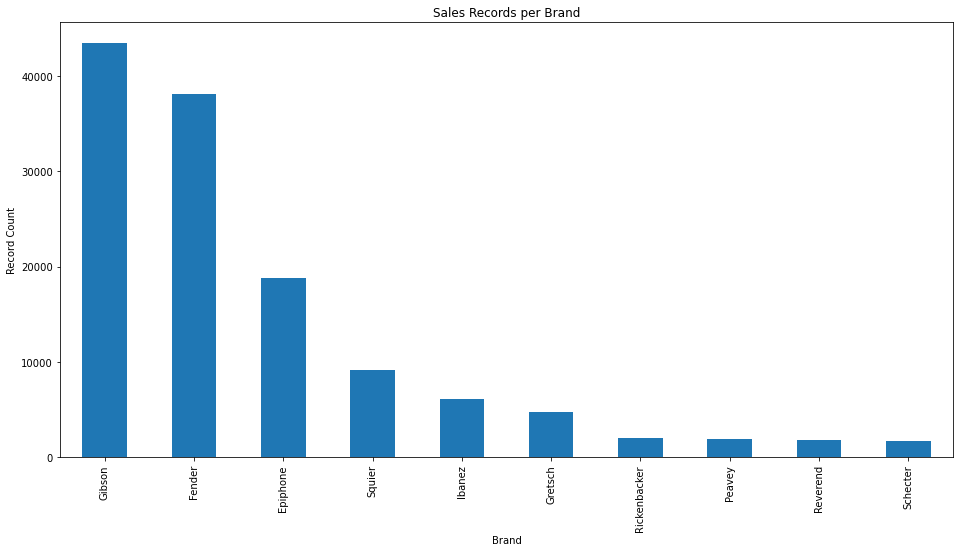

In [56]:
fig, ax = plt.subplots(figsize=(16,8))
merge_df['brand'].value_counts()[:10].plot(kind='bar', ax=ax)
ax.set_title('Sales Records per Brand')
ax.set_xlabel('Brand')
ax.set_ylabel('Record Count')

Text(0, 0.5, 'Mean Sale Amt')

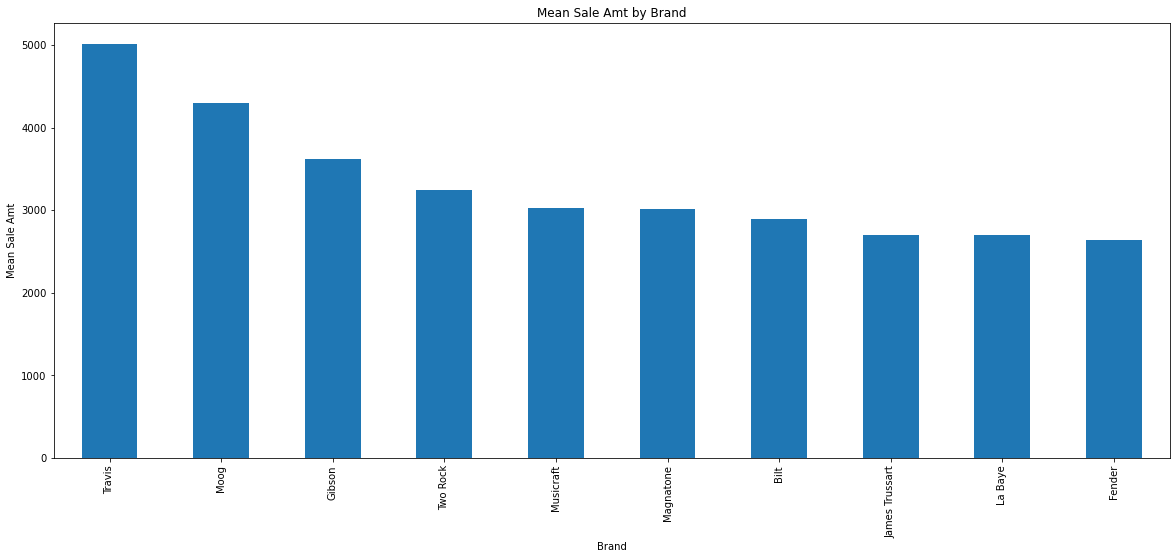

In [57]:
fig, ax = plt.subplots(figsize=(20,8))
mean_sales_by_brand = data_df.groupby('brand')['mean_sale'].mean().sort_values(ascending=False)[:10]
mean_sales_by_brand.plot(x='brand', y='mean_sale', kind='bar', ax=ax)
ax.set_title('Mean Sale Amt by Brand')
ax.set_xlabel('Brand')
ax.set_ylabel('Mean Sale Amt')


Text(0, 0.5, 'Max Sale Amt')

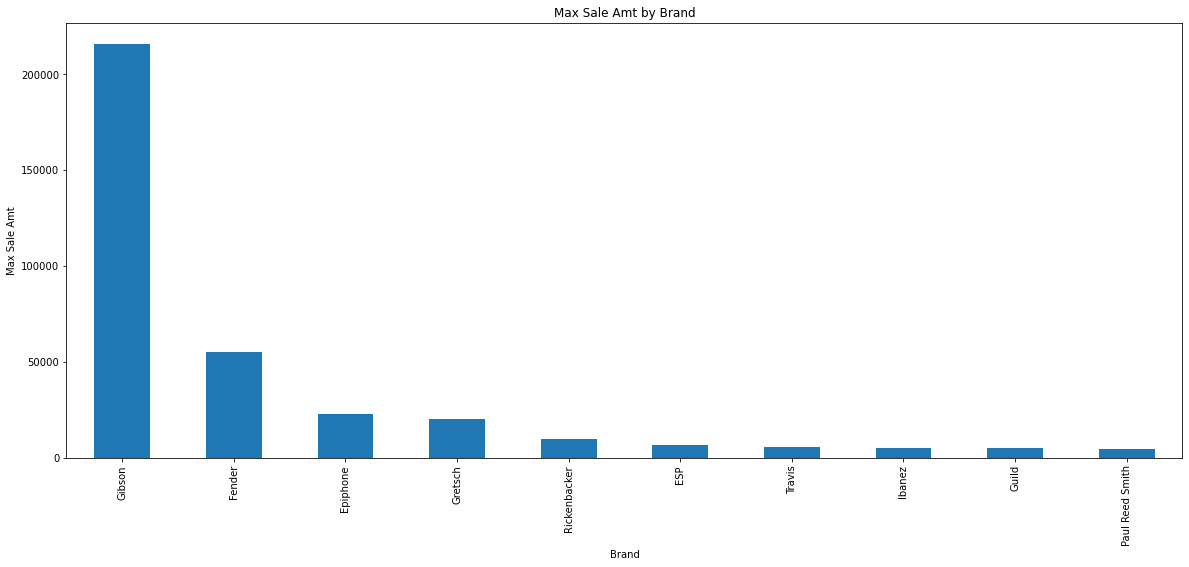

In [58]:
fig, ax = plt.subplots(figsize=(20,8))
mean_sales_by_brand = data_df.groupby('brand')['mean_sale'].max().sort_values(ascending=False)[:10]
mean_sales_by_brand.plot(x='brand', y='mean_sale', kind='bar', ax=ax)
ax.set_title('Max Sale Amt by Brand')
ax.set_xlabel('Brand')
ax.set_ylabel('Max Sale Amt')

Text(0, 0.5, 'Median Sale Amt')

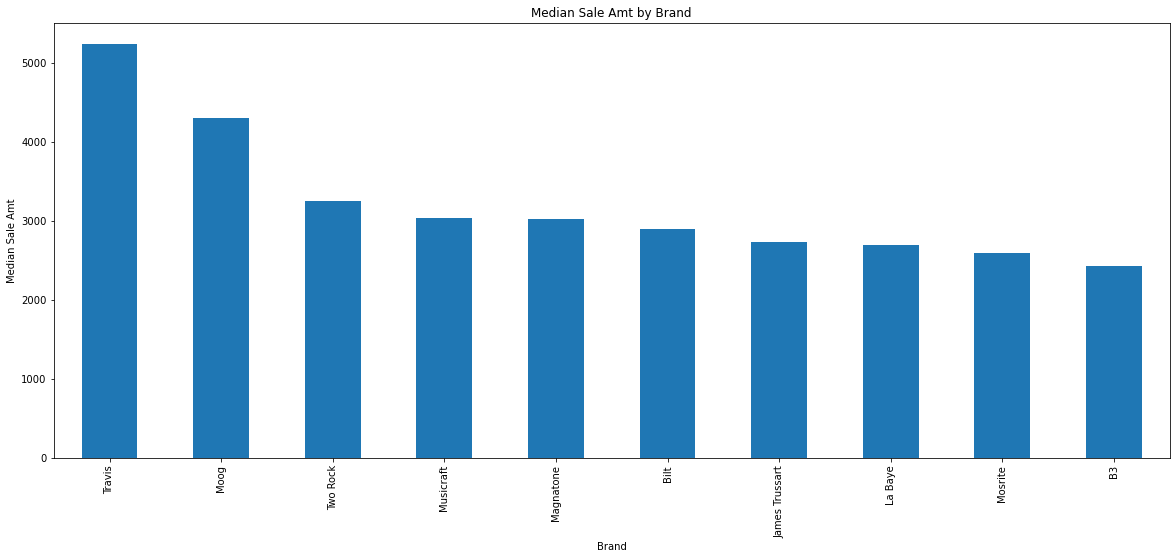

In [59]:
fig, ax = plt.subplots(figsize=(20,8))
mean_sales_by_brand = data_df.groupby('brand')['mean_sale'].median().sort_values(ascending=False)[:10]
mean_sales_by_brand.plot(x='brand', y='mean_sale', kind='bar', ax=ax)
ax.set_title('Median Sale Amt by Brand')
ax.set_xlabel('Brand')
ax.set_ylabel('Median Sale Amt')

Text(0, 0.5, 'Count of Unique Models')

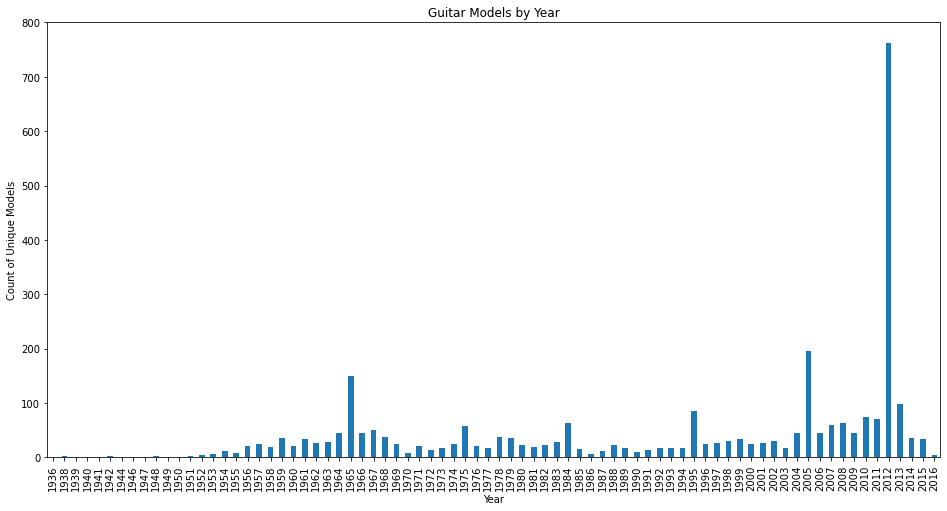

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
data_df['year'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Guitar Models by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Count of Unique Models')

Text(0, 0.5, 'Price ($)')

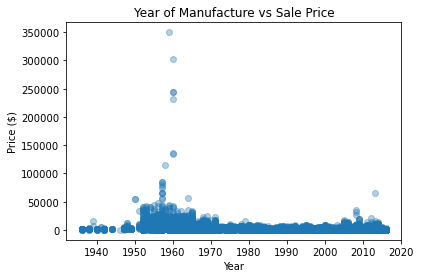

In [61]:
fig, ax = plt.subplots()
ax.scatter(merge_df['year'], merge_df['price'], alpha=0.35)
ax.set_title('Year of Manufacture vs Sale Price')
ax.set_xlabel('Year')
ax.set_ylabel('Price ($)')

Text(0, 0.5, 'Log Price ($)')

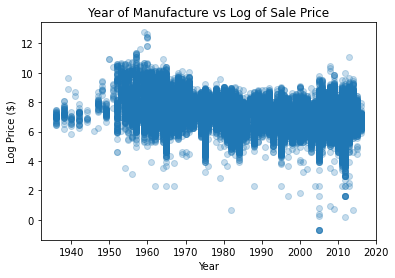

In [62]:
fig, ax = plt.subplots()
ax.scatter(merge_df['year'], np.log(merge_df['price']), alpha=0.25)
ax.set_title('Year of Manufacture vs Log of Sale Price')
ax.set_xlabel('Year')
ax.set_ylabel('Log Price ($)')

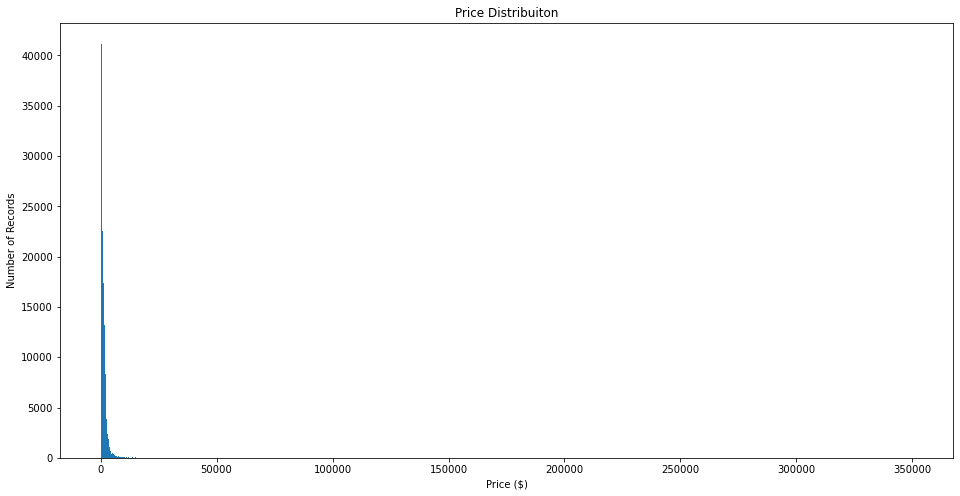

In [16]:
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(merge_df['price'], bins=1000)
ax.set_title('Price Distribuiton')
ax.set_xlabel('Price ($)')
ax.set_ylabel('Number of Records')
plt.show()

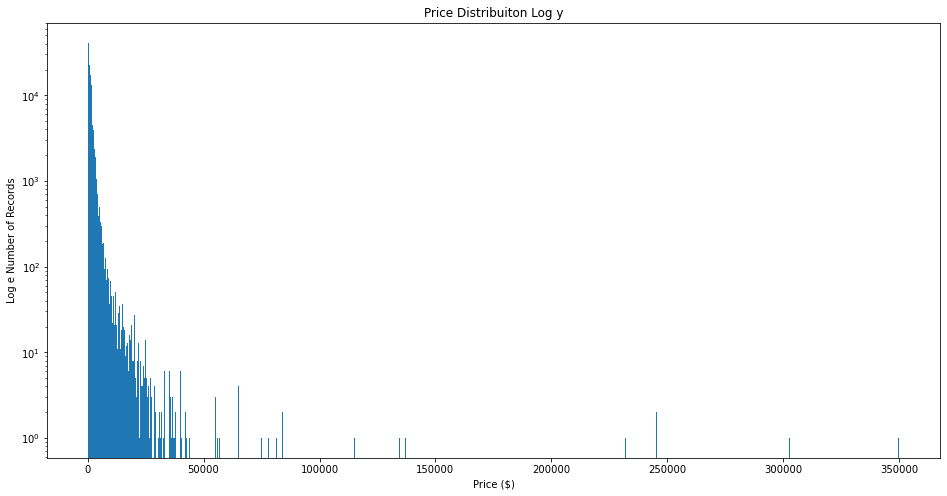

In [17]:
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(merge_df['price'], bins=1000, log=True)
ax.set_title('Price Distribuiton Log y')
ax.set_xlabel('Price ($)')
ax.set_ylabel('Log e Number of Records')
plt.show()


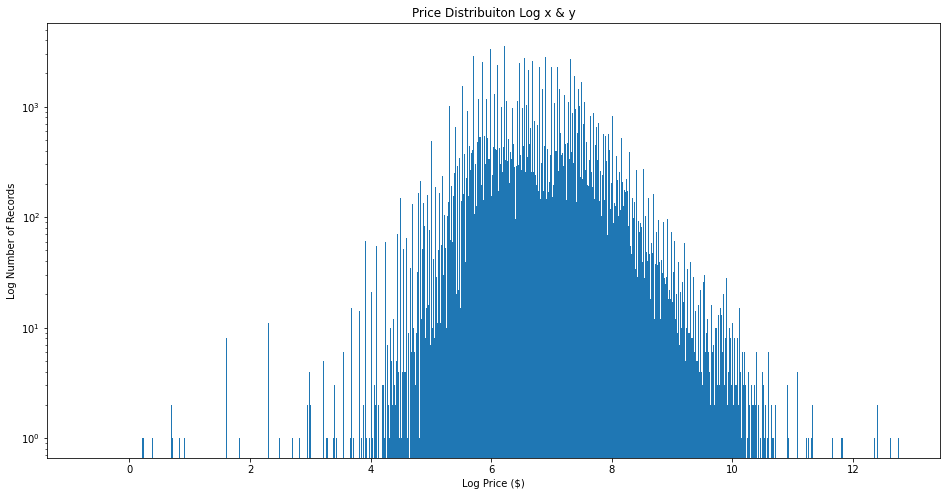

In [18]:
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(np.log(merge_df['price']), bins=1000, log=True)
ax.set_title('Price Distribuiton Log x & y')
ax.set_xlabel('Log Price ($)')
ax.set_ylabel('Log Number of Records')
plt.show()

## Dummyize merged dataframe

In [19]:
dummy_df = pd.DataFrame({
    'sale_price': merge_df['price'],
    'age_at_sale': merge_df['age_at_sale'],
    'year': merge_df['year']
})
dummy_df = pd.concat([
    dummy_df,
    pd.get_dummies(merge_df['brand'], prefix='brand'),
    pd.get_dummies(merge_df['color'], prefix='color'),
    pd.get_dummies(merge_df['cond'], prefix='cond')
], axis=1)
print(dummy_df.info())
dummy_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145161 entries, 0 to 145160
Columns: 663 entries, sale_price to cond_Very Good
dtypes: float64(1), int64(2), uint8(660)
memory usage: 95.8 MB
None


,sale_price,age_at_sale,year,brand_Airline,brand_American Showster,brand_Ampeg,brand_Aria,brand_B.C. Rich,brand_B3,brand_BC Rich,...,color_Worn Cherry,color_Worn Heritage Cherry Burst,color_Yellow,color_Yellow Burst,cond_Excellent,cond_Fair,cond_Good,cond_Mint,cond_Poor,cond_Very Good
0,6495.0,29,1992,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,4325.0,28,1992,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,7995.0,28,1992,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,5495.0,28,1992,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5800.0,28,1992,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [20]:
X = dummy_df.drop(['sale_price'], axis=1)
y = dummy_df['sale_price']

In [21]:
rf_params = {
    'n_estimators': 100,
    'max_depth': 100,
    'max_features': 'sqrt',
    'max_leaf_nodes': 1000,
    'oob_score': True,
    'n_jobs': -1,
    # 'verbose': 1
}

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
rf = RandomForestRegressor(**rf_params)

In [23]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, max_features='sqrt', max_leaf_nodes=1000,
                      n_jobs=-1, oob_score=True)

In [24]:
print(rf.score(X_test, y_test))
print(rf.oob_score_)

0.6635739324899228
0.6175016785060219


1284415.1420689626
485.80136015682353
0.6253995113128901


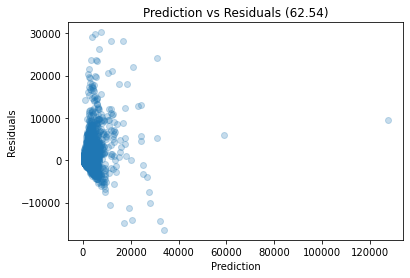

In [25]:
pred = rf.predict(X_test)
residuals = y_test - pred
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)
print(mse)
print(mae)
print(mape)
fig, ax = plt.subplots()
ax.scatter(pred, residuals, alpha=0.25)
ax.set_title(f'Prediction vs Residuals ({round(mape*100, 2)})')
ax.set_xlabel('Prediction')
ax.set_ylabel('Residuals')
plt.show()

## Let's try looking at the log of the price instead

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, np.log(y))
rf = RandomForestRegressor(**rf_params)

In [27]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, max_features='sqrt', max_leaf_nodes=1000,
                      n_jobs=-1, oob_score=True)

In [28]:
print(rf.score(X_test, y_test))
print(rf.oob_score_)

0.7218879212286057
0.7180090327423626


0.20784486335806293
0.3412623636596861
0.052172083520455444


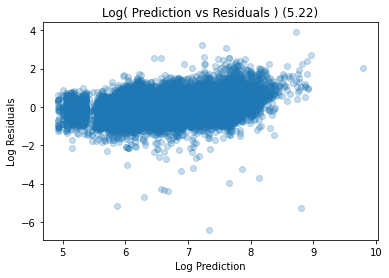

In [29]:
pred = rf.predict(X_test)
residuals = y_test - pred
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)
print(mse)
print(mae)
print(mape)
fig, ax = plt.subplots()
ax.scatter(pred, residuals, alpha=0.25)
ax.set_title(f'Log( Prediction vs Residuals ) ({round(mape*100, 2)})')
ax.set_xlabel('Log Prediction')
ax.set_ylabel('Log Residuals')
plt.show()

#### I noticed some unusually low prices, I think they're due to people trying to avoid fees on Reverb
We'll drop sales that are less than 10% the average sale price

In [30]:
df = dummy_df[dummy_df['sale_price'] > merge_df['mean_sale']*0.1]

In [31]:
X = df.drop(['sale_price'], axis=1)
y = df['sale_price']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, np.log(y))
rf = RandomForestRegressor(**rf_params)

In [33]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, max_features='sqrt', max_leaf_nodes=1000,
                      n_jobs=-1, oob_score=True)

In [34]:
print(rf.score(X_test, y_test))
print(rf.oob_score_)

0.7345862734752964
0.7356878196505823


Scores didn't change much, I think this means that the low prices weren't having much effect on the model

Our errors below did shrink though!

In [35]:
pred = rf.predict(X_test)
residuals = y_test - pred

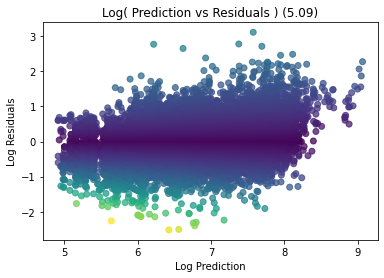

In [36]:
abs_percent_error = np.abs(y_test - pred)/y_test
mape = np.mean(abs_percent_error)
a_sort = abs_percent_error.argsort()
fig, ax = plt.subplots()
ax.scatter(pred[a_sort], residuals.iloc[a_sort], alpha=0.75, c=abs_percent_error.iloc[a_sort])
ax.set_title(f'Log( Prediction vs Residuals ) ({round(mape*100, 2)})')
ax.set_xlabel('Log Prediction')
ax.set_ylabel('Log Residuals')
plt.show()

### FEATURE IMPORTANCES
I have a lot of features, many of them with low importance. I want to try dropping some of these.

In [37]:
feat_scores = pd.Series(rf.feature_importances_, index=X.columns)

0.0005 feels like a good threshold because I'm still left with > 100 features and it captures all condition features

In [38]:
for cond in sales_df['cond'].unique():
    print(cond, ' '*(10-len(cond)), feat_scores['cond_' + cond])

Excellent   0.0048384528049024945
Mint        0.004544762549561646
Good        0.0073990495590862786
Very Good   0.0029918855686006406
Fair        0.004944292840937076
Poor        0.0007401106226589017


In [39]:
X.loc[:, np.array(feat_scores > 0.0005)]

,age_at_sale,year,brand_Ampeg,brand_Danelectro,brand_Duesenberg,brand_ESP,brand_Epiphone,brand_Fano,brand_Fender,brand_G&L,...,color_White,color_Wine Red,color_Worn Brown,color_Worn Cherry,cond_Excellent,cond_Fair,cond_Good,cond_Mint,cond_Poor,cond_Very Good
0,29,1992,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,28,1992,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,28,1992,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,28,1992,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,28,1992,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145156,78,1940,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
145157,77,1940,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
145158,77,1940,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
145159,77,1940,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Text(0, 0.5, 'Features')

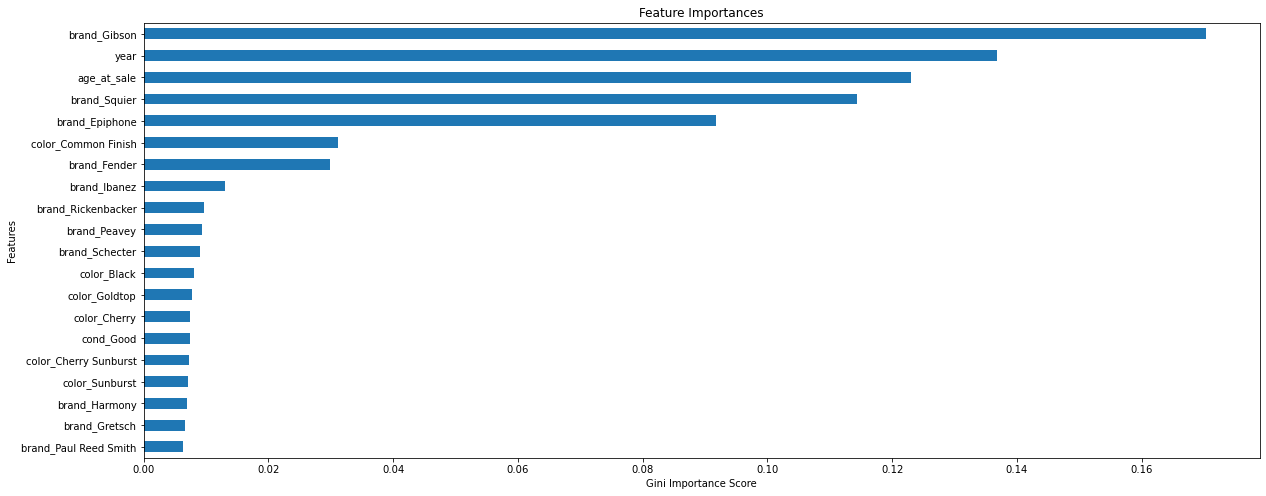

In [64]:
ax = feat_scores[feat_scores > 0.0005].sort_values(ascending=False)[:20][::-1].plot(kind='barh', figsize=(20,8))
ax.set_title('Feature Importances')
ax.set_xlabel('Gini Importance Score')
ax.set_ylabel('Features')

In [41]:
X = X.loc[:, np.array(feat_scores > 0.0005)]
y = df['sale_price']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, np.log(y))
rf = RandomForestRegressor(**rf_params)

In [43]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, max_features='sqrt', max_leaf_nodes=1000,
                      n_jobs=-1, oob_score=True)

In [75]:
with open('app/static/rfr_trained.pkl', 'wb') as f:
    pkl.dump(rf, f)

A bit of improvement in score, but the forest regressor runs MUCH faster  
This should make a grid search easier

In [44]:
print(rf.score(X_test, y_test))
print(rf.score(X_train, y_train))
print(rf.oob_score_)

0.7506108601286996
0.7629308964643995
0.7503089920863901


In [45]:
pred = np.exp(rf.predict(X_test))
y_test_e = np.exp(y_test)
residuals = y_test_e - pred

(-10000.0, 50000.0)

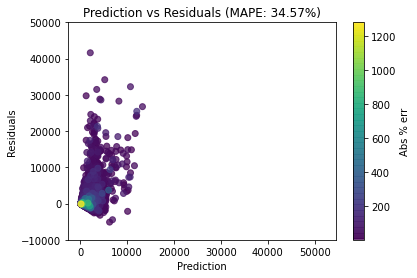

In [47]:
abs_percent_error = (np.abs(y_test_e - pred)/y_test_e)*100
mape = np.mean(abs_percent_error)
a_sort = abs_percent_error.argsort()
fig, ax = plt.subplots()
scatter = ax.scatter(pred, residuals, alpha=0.75, c=abs_percent_error.iloc[a_sort])
ax.set_title(f'Prediction vs Residuals (MAPE: {round(mape, 2)}%)')
ax.set_xlabel('Prediction')
ax.set_ylabel('Residuals')
cb = fig.colorbar(scatter, ax=ax)
cb.set_label('Abs % err')
# ax.set_ylim(-10000,50000)

In [48]:
abs_percent_error.describe()

count    36266.000000
mean        34.569728
std         38.232457
min          0.000324
25%         12.210838
50%         25.805293
75%         44.509334
max       1278.819745
Name: sale_price, dtype: float64

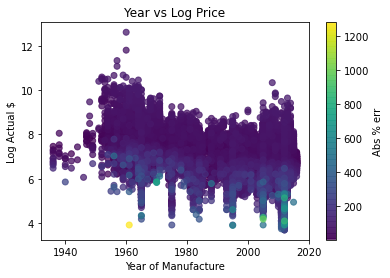

In [68]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_test['year'].iloc[a_sort], np.log(y_test_e.iloc[a_sort]), c=abs_percent_error.iloc[a_sort], alpha=0.75)
ax.set_title('Year vs Log Price')
ax.set_xlabel('Year of Manufacture')
ax.set_ylabel('Log Actual $')
cb = fig.colorbar(scatter, ax=ax)
cb.set_label('Abs % err')

In [50]:
ra = residuals.argsort()
idxs = residuals.index[ra]
pred[ra]

array([ 6254.52878255,  6876.24121328,  4227.91738438, ...,
       13980.34871426, 51955.01688865, 19538.34468906])

In [51]:
# params = {
#     'n_estimators': np.arange(50, 501, 50),
#     'max_depth': np.arange(25, 201, 25),
#     'max_features': ['sqrt', 'log2'],
#     'max_leaf_nodes': np.arange(100, 1001, 200),
#     'oob_score': [True],
#     'n_jobs': [-1],
#     'verbose': [2]
# }

# gs = GridSearchCV(
#     RandomForestRegressor(),
#     params,
#     cv=5,
#     n_jobs=-1
# )

# gs.fit(X_train, y_train)
# gsdf = pd.DataFrame(gs.cv_results_)

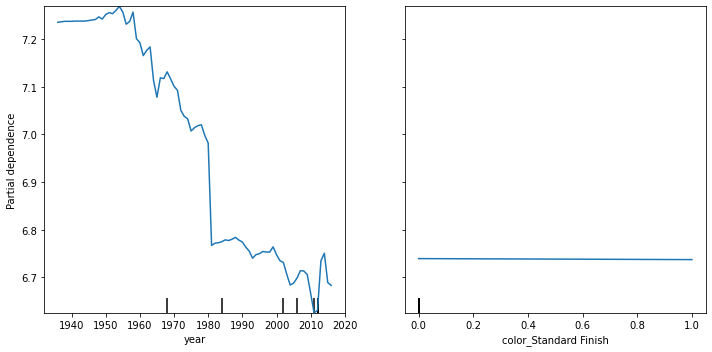

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
f = feat_scores.argsort()[::-1]
plot_partial_dependence(rf, X_train, [f[1], f[3]], target=1, ax=ax)
plt.tight_layout()

In [53]:
# result = permutation_importance(rf, X_test, y_test, n_repeats=10, n_jobs=-1)
# sorted_idx = result.importances_mean.argsort()[:50]

# fig, ax = plt.subplots()
# ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
# plt.show()

In [54]:
merge_df[merge_df['price'] > 50000]

,title,brand,model,year,color,est_low,est_high,text,mean_sale,num_records,year_str,date,cond,price,age_at_sale
3914,Epiphone Sheraton 1964 Sunburst,Epiphone,Sheraton,1964,Sunburst,4500.0,7000.0,Whereas the Epiphone Casino was a full hollowb...,22933.33,3,1964,2015-09-29,Very Good,56000.00,51
4015,Fender Broadcaster 1950 Blonde,Fender,Broadcaster,1950,Blonde,40000.0,60000.0,Fender introduced the Broadcaster as a replace...,55000.00,2,1950,2017-02-08,Excellent,55000.00,67
4016,Fender Broadcaster 1950 Blonde,Fender,Broadcaster,1950,Blonde,40000.0,60000.0,Fender introduced the Broadcaster as a replace...,55000.00,2,1950,2012-12-19,Very Good,55000.00,62
4985,Gibson Les Paul Custom 1957 Ebony,Gibson,Les Paul Custom,1957,Ebony,18715.0,47280.0,The Gibson Les Paul may carry the distinction ...,30059.82,11,1957,2021-03-05,Excellent,57000.00,64
5095,Gibson Les Paul Standard 1960 Burst,Gibson,Les Paul Standard,1960,Burst,140000.0,240000.0,The Gibson Les Paul Standard stands as one of ...,215965.18,6,1960,2016-10-20,Good,231870.36,56
5096,Gibson Les Paul Standard 1960 Burst,Gibson,Les Paul Standard,1960,Burst,140000.0,240000.0,The Gibson Les Paul Standard stands as one of ...,215965.18,6,1960,2016-09-07,Excellent,302420.71,56
5097,Gibson Les Paul Standard 1960 Burst,Gibson,Les Paul Standard,1960,Burst,140000.0,240000.0,The Gibson Les Paul Standard stands as one of ...,215965.18,6,1960,2014-05-12,Very Good,245000.00,54
5098,Gibson Les Paul Standard 1960 Burst,Gibson,Les Paul Standard,1960,Burst,140000.0,240000.0,The Gibson Les Paul Standard stands as one of ...,215965.18,6,1960,2014-02-15,Good,137000.00,54
5099,Gibson Les Paul Standard 1960 Burst,Gibson,Les Paul Standard,1960,Burst,140000.0,240000.0,The Gibson Les Paul Standard stands as one of ...,215965.18,6,1960,2014-02-09,Very Good,245000.00,54
5100,Gibson Les Paul Standard 1960 Burst,Gibson,Les Paul Standard,1960,Burst,140000.0,240000.0,The Gibson Les Paul Standard stands as one of ...,215965.18,6,1960,2013-04-20,Very Good,134500.00,53


In [55]:
for doc in link_coll.find({'title': 'Gibson Les Paul Standard 1959 Burst'}, {'html': 0}):
    print(doc)

{'_id': ObjectId('6054ef739af17e64c83e04c3'), 'title': 'Gibson Les Paul Standard 1959 Burst', 'link': 'https://reverb.com/price-guide/guide/19833-gibson-les-paul-standard-1959-burst'}
